# Dynamic Time Warping for Non-Anthropomorphic Hand Data

In [1]:
# Set up:
# %matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook

import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import *

mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# import plotly.graph_objects as go
# import plotly.express as px
# import ipywidgets as widget

# Computation packages
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks
from fastdtw import fastdtw

In [2]:
from nah.alignments import dtw_data_import

from nah.plot import plot_norm, plot_pos, plot_rot, plot_raw_data, plot_raw_data_subsampled

In [3]:
def norm_data(x,y):

    # Separate time from position
    # x = (end_eff_data[...,0],end_eff_data[...,1])
    # y = (hand_data[...,0],hand_data[...,1])
    
    
    # Normalize x and y to prevent scaling issues from creating DTW misalignment

    scale_x = 1/(np.max(x[1])-np.min(x[1]))
    scale_y = 1/(np.max(y[1])-np.min(y[1]))
    
    # Center should not be the mean; it should center based on the max and min
    # center_x = np.mean(x[1])
    # center_y = np.mean(y[1])
    center_x = np.min(x[1])
    center_y = np.min(y[1])

    x_norm = np.vstack((x[0],(x[1] - center_x)*scale_x))
    y_norm = np.vstack((y[0],(y[1] - center_y)*scale_y))

    # TO-DO: trim ends for cleaner DTW
    # (Not done yet)
    
    # If X and Y are different lengths, fastdtw has issues
    lim = min(x.shape[1],y.shape[1])

    dtw_distance, warp_path = fastdtw(x_norm[1,0:lim], y_norm[1,0:lim]) #, dist=euclidean) 
    plot_norm(warp_path, x_norm, y_norm)
    # dtw_distance, warp_path = fastdtw(x[1,0:lim], y[1,0:lim])
    # plot_norm(warp_path, x,y)
    
    return warp_path

In [4]:
# Take the warp_path generated from normalized hand/URDF data and use that to align all other hand data
def full_align(warp_path, end_eff_data, hand_data):
    # Time marks: 
    time_URDF = end_eff_data[...,0]
    time_hand = hand_data[...,0]

    # remember that x = end_eff_pos
    #               y = hand_pos

    # Z-data (forward/back) is offset by the distance between the viewer and the robot. Let's remove that distance for comparison purposes

    wp_size = len(warp_path)
    time_URDF_aligned = np.zeros(wp_size)
    time_hand_aligned = np.zeros(wp_size)
    end_eff_pos_aligned = np.zeros((wp_size,3))
    end_eff_rot_aligned = np.zeros((wp_size,3))
    hand_pos_aligned = np.zeros((wp_size,3))
    hand_rot_aligned = np.zeros((wp_size,3))

    for i, [map_x, map_y] in enumerate(warp_path, start=0):   
        time_URDF_aligned[i] = time_URDF[map_x]
        time_hand_aligned[i] = time_hand[map_y]
        end_eff_pos_aligned[i][0:3] = end_eff_data[map_x][1:4]
        end_eff_rot_aligned[i][0:3] = end_eff_data[map_x][4:]
        hand_pos_aligned[i][0:3]    = hand_data[map_y][1:4]
        hand_rot_aligned[i][0:3]    = hand_data[map_y][4:]
    
    return time_URDF_aligned, time_hand_aligned, end_eff_pos_aligned, end_eff_rot_aligned, hand_pos_aligned, hand_rot_aligned

def full_joint_align(time_URDF_aligned, joint_data):
    # Time marks: 
    time_ja   = joint_data[...,0]

    # remember that x = end_eff_pos
    #               y = hand_pos

    # Z-data (forward/back) is offset by the distance between the viewer and the robot. Let's remove that distance for comparison purposes

    wp_size = len(warp_path)
    time_ja_aligned   = np.zeros(wp_size)
    joint_data_aligned = np.zeros((wp_size,6))

    for i, [map_x, map_y] in enumerate(warp_path, start=0):   
        time_ja_aligned[i]   = time_ja[map_x]
        time_hand_aligned[i] = time_hand[map_y]
        joint_data_aligned[i][0:5] = end_eff_data[map_x][1:6]
        hand_data_aligned[i][0:5]    = hand_data[map_y][1:6]
    
    return time_ja_aligned, joint_data_aligned

In [5]:
def clean_rot_data(gesture_num, demo_num, hand_rot_aligned):
    # Fix angle inversion issues for hand data

    fig, ax = plt.subplots(figsize=(10, 7))

    for i, [x_rot,y_rot,z_rot] in enumerate(hand_rot_aligned, start=1):
        # Singularities should occur in all axes simultaneously
        if i==len(hand_rot_aligned):
            continue
        elif np.abs(hand_rot_aligned[i].T[0] - hand_rot_aligned[i-1].T[0])>np.abs(hand_rot_aligned[i].T[0] + hand_rot_aligned[i-1].T[0]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-1], hand_rot_aligned[i])
            hand_rot_aligned[i] = -hand_rot_aligned[i]
        elif np.abs(hand_rot_aligned[i].T[1] - hand_rot_aligned[i-1].T[1])>np.abs(hand_rot_aligned[i].T[1] + hand_rot_aligned[i-1].T[1]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-1], hand_rot_aligned[i])
            hand_rot_aligned[i] = -hand_rot_aligned[i]
        elif np.abs(hand_rot_aligned[i].T[2] - hand_rot_aligned[i-1].T[2])>np.abs(hand_rot_aligned[i].T[2] + hand_rot_aligned[i-1].T[2]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-1], hand_rot_aligned[i])
            hand_rot_aligned[i] = -hand_rot_aligned[i]


    # for i, [x_rot,y_rot,z_rot] in enumerate(hand_rot_aligned, start=2):
    #     # Singularities should occur in all axes simultaneously
    #     if np.abs(hand_rot_aligned[i].T[0] - hand_rot_aligned[i-2].T[0])>np.abs(hand_rot_aligned[i].T[0] + hand_rot_aligned[i-2].T[0]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-2], hand_rot_aligned[i])
    #         hand_rot_aligned[i] = -hand_rot_aligned[i]
    #     elif np.abs(hand_rot_aligned[i].T[1] - hand_rot_aligned[i-2].T[1])>np.abs(hand_rot_aligned[i].T[1] + hand_rot_aligned[i-2].T[1]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-2], hand_rot_aligned[i])
    #         hand_rot_aligned[i] = -hand_rot_aligned[i]
    #     elif np.abs(hand_rot_aligned[i].T[2] - hand_rot_aligned[i-2].T[2])>np.abs(hand_rot_aligned[i].T[2] + hand_rot_aligned[i-2].T[2]):
    #         print(time_hand_aligned[i], hand_rot_aligned[i-2], hand_rot_aligned[i])
    #         hand_rot_aligned[i] = -hand_rot_aligned[i]

    ax.plot(time_hand_aligned, hand_rot_aligned[:].T[0], '-ko', label='x', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
    ax.plot(time_hand_aligned, hand_rot_aligned[:].T[1], '-bo', label='x', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')
    ax.plot(time_hand_aligned, hand_rot_aligned[:].T[2], '-ro', label='x', linewidth=0.2, markersize=2, markerfacecolor='red', markeredgecolor='red')

    plt.savefig('DTW_Rot_corrected_'+str(demo_num)+'.png')
    plt.close('all')
    
    return hand_rot_aligned

In [6]:
def load_npzs(robot_name, PID, followup, gesture_num):
    try:
        if followup:
            filename = "C:\\Users\\jmoln\\Dropbox (GaTech)\\Non-Anthropomorphic Hands User Study Data\\npz files\\data_PID"+str(PID)+"B_"+str(robot_name)+"_gesture_"+str(gesture_num)+".npz"
        else:
            filename = "C:\\Users\\jmoln\\Dropbox (GaTech)\\Non-Anthropomorphic Hands User Study Data\\npz files\\data_PID"+str(PID)+"_"+str(robot_name)+"_gesture_"+str(gesture_num)+".npz"
    except:
        print(filename+" NOT FOUND")
    # Import data from csvs
    data = np.load(filename)
    end_eff_data = data['end_eff_data']
    camera_data  = data['camera_data']
    rh_data      = data['rh_data']
    lh_data      = data['lh_data']
    joint_data   = data['joint_data']
    
    return end_eff_data, camera_data, rh_data, lh_data, joint_data

In [7]:
def segmentbydemo(end_eff_data, camera_data, rh_data, lh_data, joint_data, demo_max):    
    peaks, _ = find_peaks(end_eff_data[:,0], height=0)
    
    end_eff=['']*demo_max
    camera =['']*demo_max
    rh     =['']*demo_max
    lh     =['']*demo_max
    joints =['']*demo_max

    for i in range(0,demo_max):
        if i==0:
            end_eff[i] = end_eff_data[1:peaks[0],:]
            camera[i]  =  camera_data[1:peaks[0],:]
            rh[i]      =      rh_data[1:peaks[0],:]
            lh[i]      =      lh_data[1:peaks[0],:]
            joints[i]  =   joint_data[1:peaks[0],:]
        else:
            end_eff[i] = end_eff_data[peaks[i-1]:peaks[i],:]
            camera[i]  =  camera_data[peaks[i-1]:peaks[i],:]
            rh[i]      =      rh_data[peaks[i-1]:peaks[i],:]
            lh[i]      =      lh_data[peaks[i-1]:peaks[i],:]
            joints[i]  =   joint_data[peaks[i-1]:peaks[i],:]

    # end_eff = np.array(end_eff)
    # rh      = np.array(rh)
    # lh      = np.array(lh)
    # joints  = np.array(joints)
    return end_eff, camera, rh, lh, joints

def sumofsquares(a):
    return np.vstack((a[:,0],np.sum(np.multiply(a[:,1:7],a[:,1:7]),axis=1)))

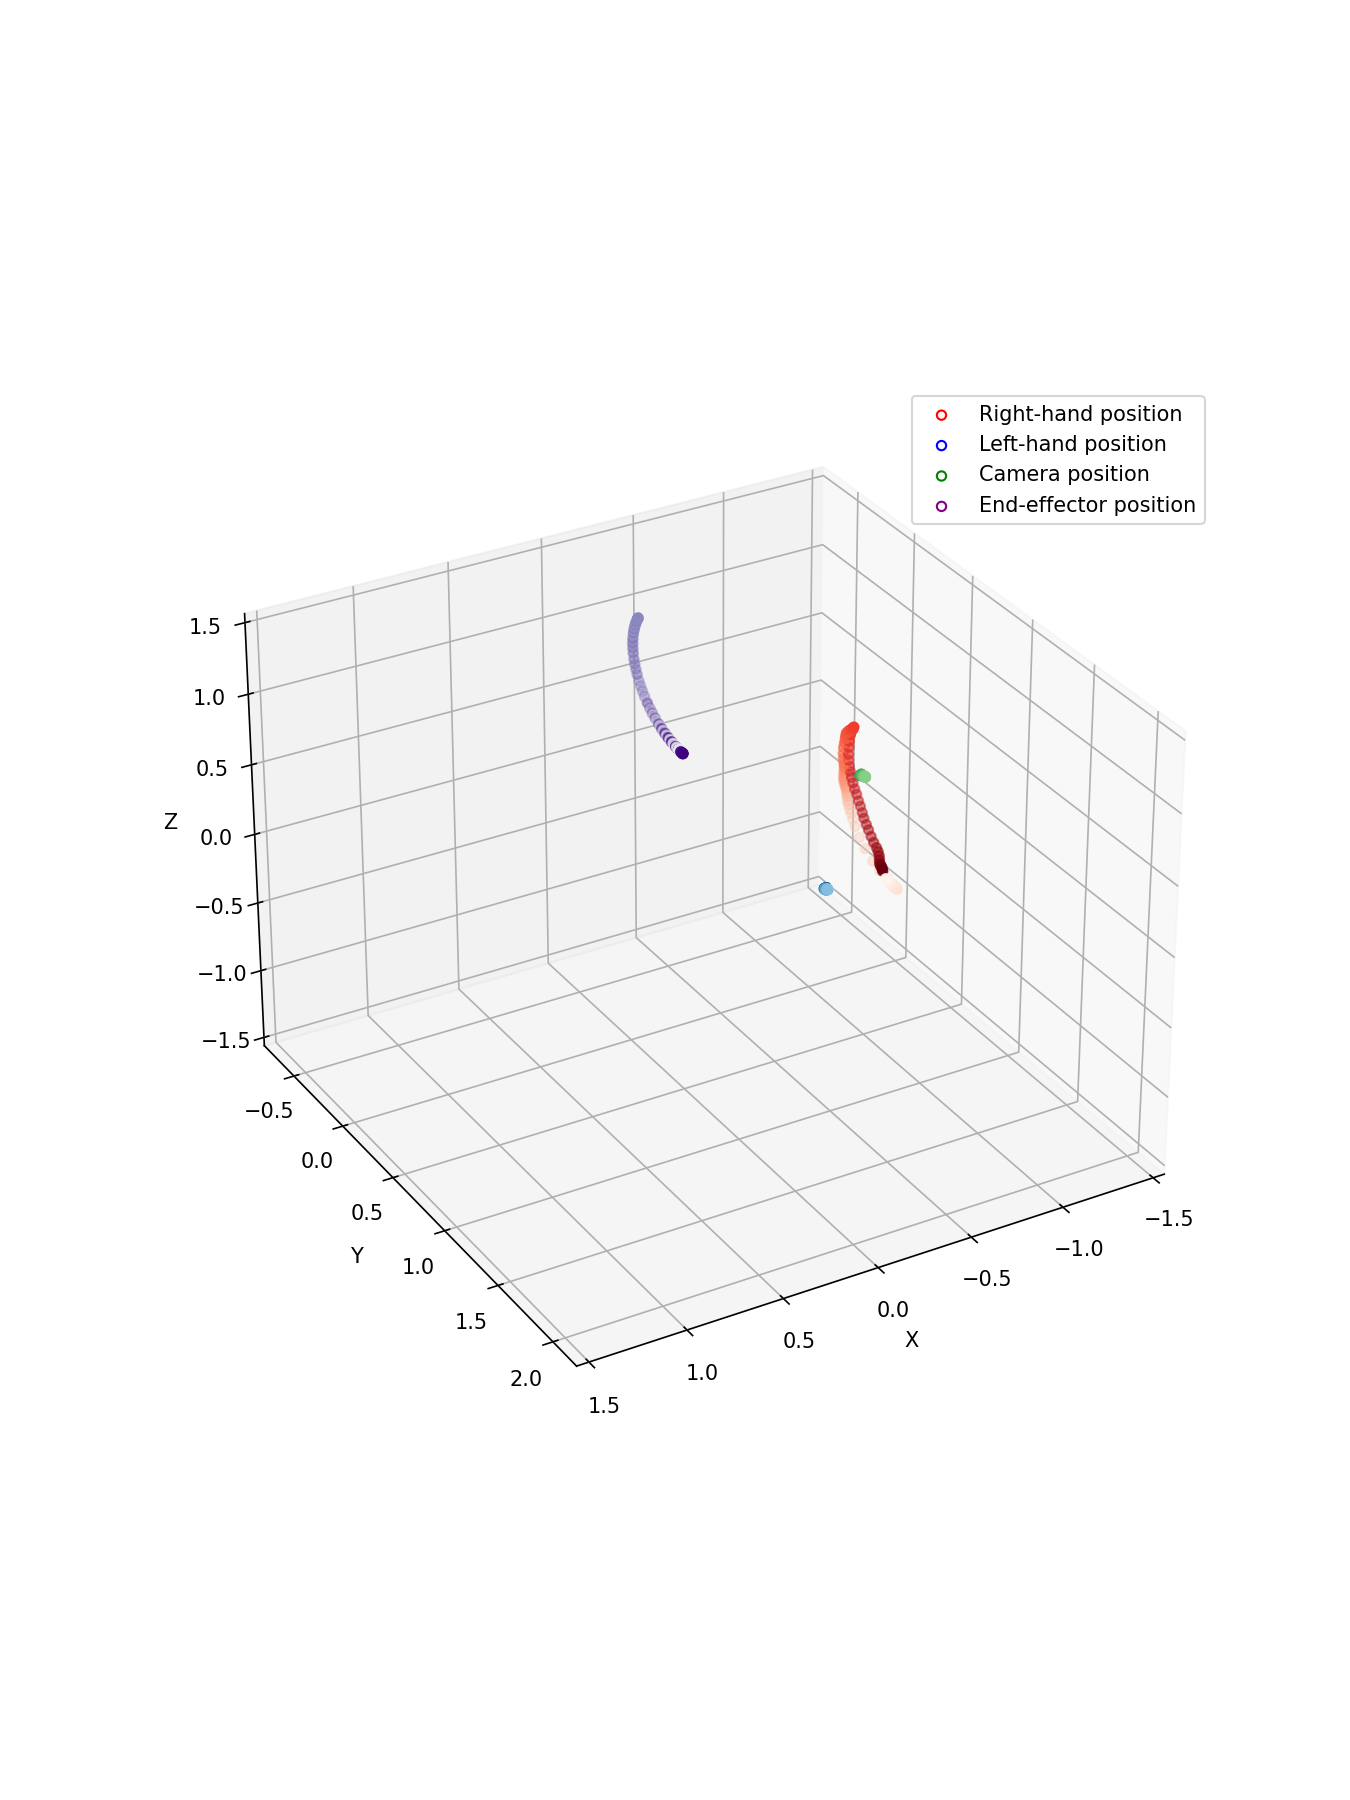

In [8]:
%matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook

# robot_name='j2s6s300'
robot_name='Reachy'
gesture_num=1


total_end_eff = np.array([])
total_camera  = np.array([])
total_rh      = np.array([])
total_lh      = np.array([])
total_joint   = np.array([])

singlePID=True
singlePIDval = 13
followup = False

if singlePID:
    PID_begin_range=singlePIDval
    PID_end_range=singlePIDval+1 #Don't forget to +1 to whatever your last PID is
else:
    PID_begin_range=1
    if followup:
        PID_end_range=10 #Don't forget to +1 to whatever your last PID is
    else:
        PID_end_range=17
for PID in range(PID_begin_range,PID_end_range):
    end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)
    if (PID==PID_begin_range):
        total_end_eff = end_eff
        total_camera = camera
        total_rh = rh
        total_lh = lh
        total_joint = joint
    else:
        total_end_eff = np.vstack((total_end_eff,end_eff))
        total_camera  = np.vstack((total_camera,camera))
        total_rh      = np.vstack((total_rh,rh))
        total_lh      = np.vstack((total_lh,lh))
        total_joint   = np.vstack((total_joint,joint))
# plot_raw_data(end_eff, rh, lh, camera, joint, start_index, end_index)
# plot_raw_data_subsampled(5, total_end_eff, total_camera, total_rh, total_lh, total_joint)

demo_max=2
end_eff, camera, rh, lh, joints = segmentbydemo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
for i in range(1):
    plot_raw_data_subsampled(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])


In [9]:
from evo.core import metrics, sync
from evo.core.trajectory import PoseTrajectory3D
from scipy.spatial.transform import Rotation
from copy import deepcopy

In [16]:
def get_evo_trajectory(traj):
    """timestamp, tx, ty, tz, rx, ry, rz"""
    timestamps = traj[:, 0]
    xyz = traj[:, 1:4]

    euler_angles = traj[:, 4:7]
    Rs = Rotation.from_euler('xyz', euler_angles)
    quat_xyzw = Rs.as_quat()
    quat_wxyz = quat_xyzw[:, (3, 0, 1, 2)]
    
    return PoseTrajectory3D(positions_xyz=xyz,
                           orientations_quat_wxyz=quat_wxyz,
                           timestamps=timestamps)

def evo_sync(traj1: PoseTrajectory3D, traj2: PoseTrajectory3D):
    """Synchronize trajectories using Evo's associate_trajectories method"""
    traj1, traj2 = sync.associate_trajectories(traj1, traj2)
    return traj1, traj2
    

def align(traj1, traj2, correct_scale=True):
    """
    Align the first trajectory to the second one.
    Returns the aligned first trajectory.
    """
    traj1_aligned = deepcopy(traj1)
    r, t, s = traj1_aligned.align(traj2, correct_scale=correct_scale)
    print(r, t, s)
    return traj1_aligned
    
def evaluate_ape(traj1: PoseTrajectory3D, traj2: PoseTrajectory3D):
    metric = metrics.APE(metrics.PoseRelation.full_transformation)
    metric.process_data((traj1, traj2))
    
    return metric

In [17]:
end_eff_traj = get_evo_trajectory(end_eff[0])
right_hand_traj = get_evo_trajectory(rh[0])

In [18]:
end_eff_traj, right_hand_traj = evo_sync(end_eff_traj, right_hand_traj)

metric = evaluate_ape(end_eff_traj, right_hand_traj)
print(metric.get_all_statistics())

right_hand_traj = align(right_hand_traj, end_eff_traj)

{'rmse': 3.086409048090351, 'mean': 3.086138294633864, 'median': 3.092836790690064, 'std': 0.04088078434148283, 'min': 2.9732190201648176, 'max': 3.154032159557498, 'sse': 3810.3683248535954}
[[ 0.99516175 -0.04339348 -0.08814815]
 [ 0.06398426  0.96708303  0.24628524]
 [ 0.07455941 -0.25073375  0.96518054]] [ 0.06057627 -0.795828   -1.48261079] 0.9104939879100497


In [19]:
def convert_evo_to_np(traj: PoseTrajectory3D, shape):
    array = np.empty(shape)
    array[:, 0] = traj.timestamps
    array[:, 1:4] = traj.positions_xyz
    array[:, 4:7] = traj.get_orientations_euler()
    return array

end_eff_aligned = convert_evo_to_np(end_eff_traj, end_eff[0].shape)
print(end_eff_aligned.shape)

rh_aligned = convert_evo_to_np(right_hand_traj, rh[0].shape)
print(rh_aligned.shape)

(400, 7)
(400, 7)


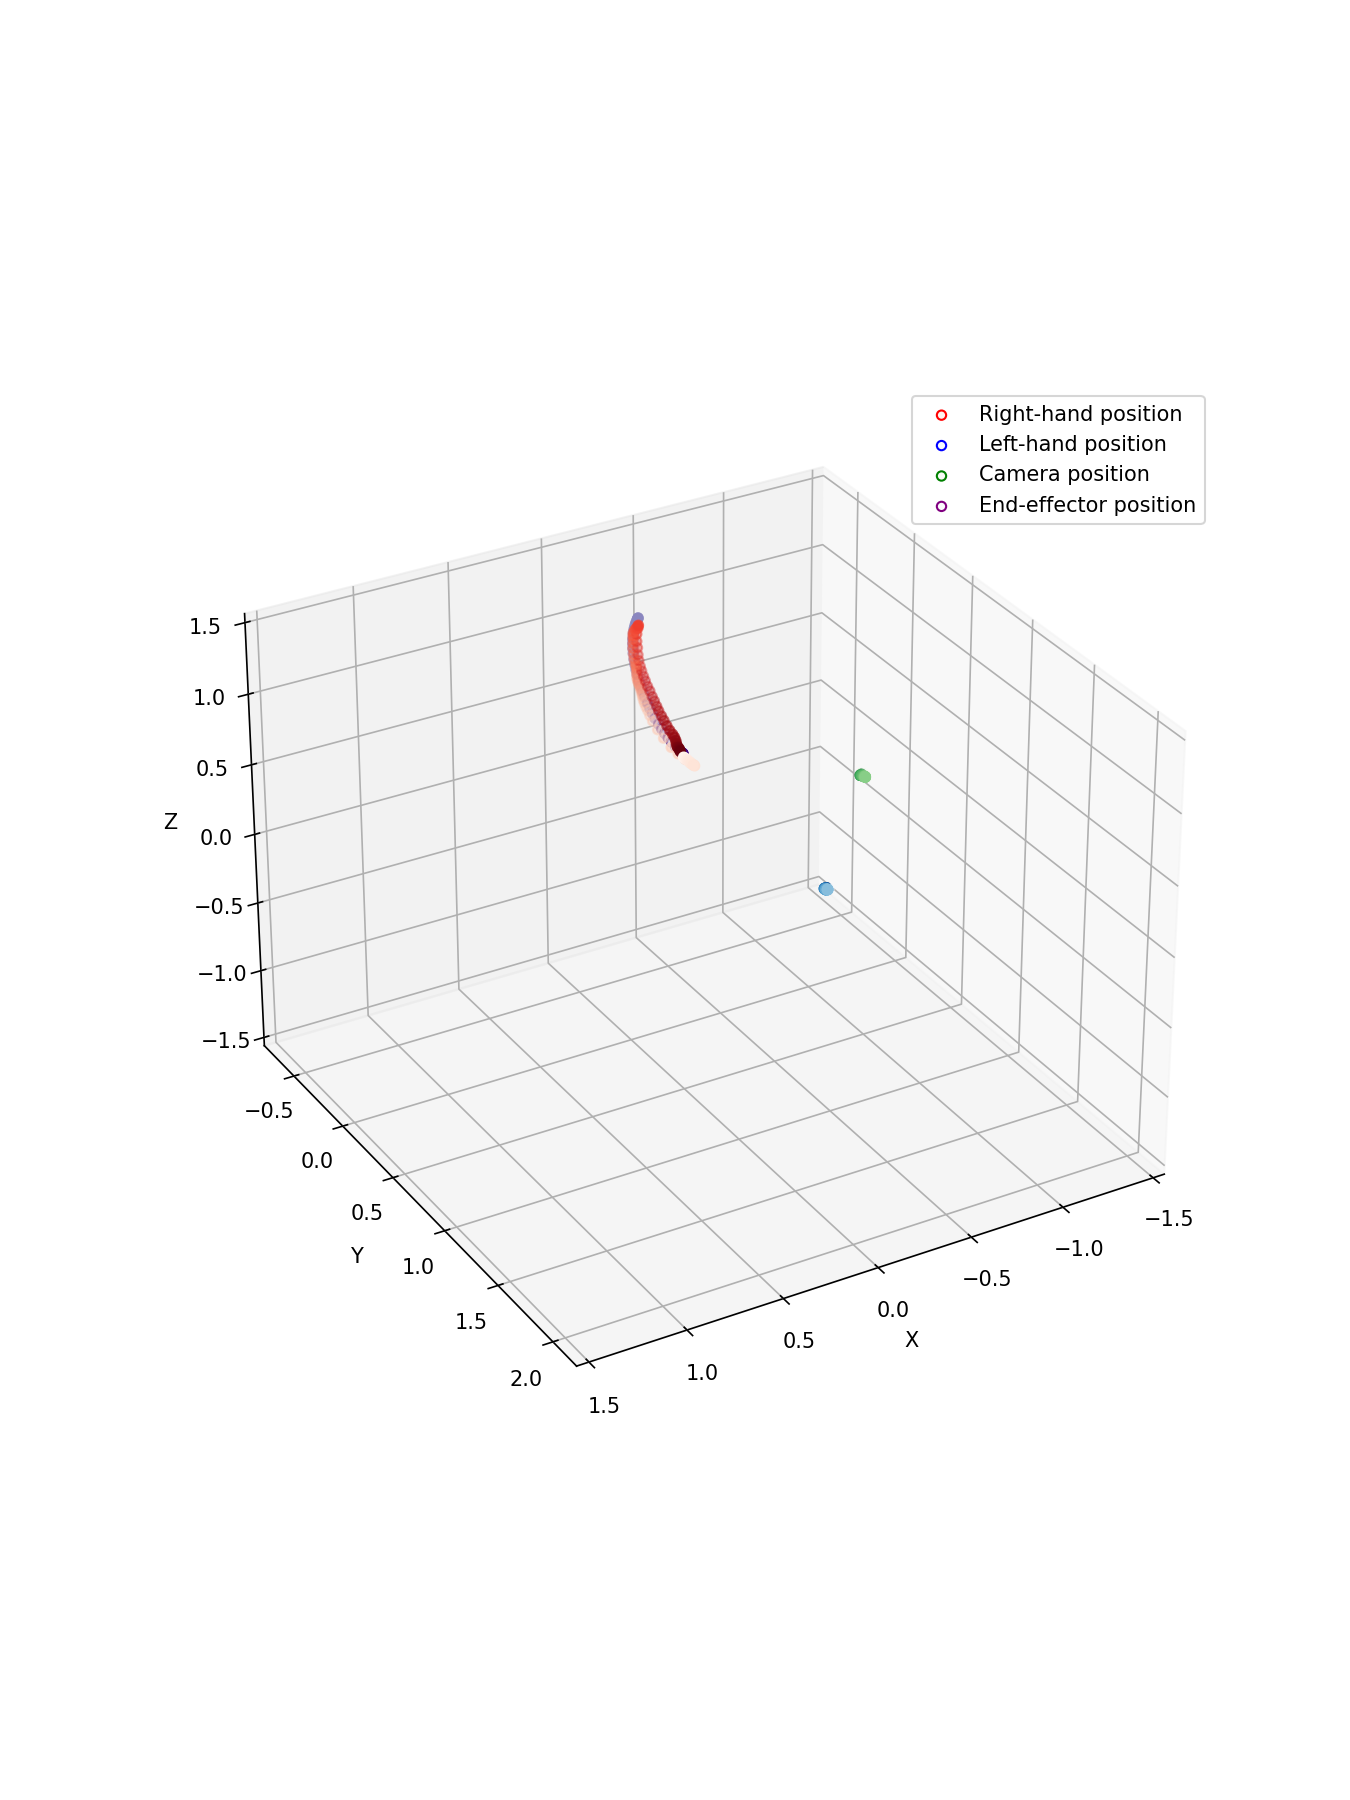

In [20]:
plot_raw_data_subsampled(5, end_eff_aligned, camera[0], rh_aligned, lh[0], joint[0])

In [21]:
metric = evaluate_ape(end_eff_traj, right_hand_traj)
metric.get_all_statistics()

{'rmse': 2.3390962917376417,
 'mean': 2.33859344288017,
 'median': 2.3473526310881994,
 'std': 0.04849918492779447,
 'min': 2.2510886788807567,
 'max': 2.4256679546115083,
 'sse': 2188.548584808315}